# <span style="color:red"> 4-cycle clustering </span>

Suppose we have a left layer, $L$ with weights $L_{l,i}$ corresponding from node $l$ in the layer to node $i$ in the middle layer. And suppose we have a right layer $R$ with weights $R_{i,r}$ corresponding to the weight from node $i$ in the middle layer and node $r$ in the right layer. 

So for nodes $i, j$ in the middle layer, we can calculate the four-cycle clustering coefficient corresponding to it. 

$$ C_{\text{4-cylce, i}} = \frac{1}{n_L n_R (n-1)} \sum_{\substack{j \neq i\\l \leq n_L\\r \leq n_R}} \hat{L}_{l,i} \hat{L}_{l,j} \hat{R}_{i,r} \hat{R}_{j,r}$$


Where $\hat{L}_{l,i} = \sqrt[4]{\frac{|L_{l,i}|}{\text{max}_l(|L_{l,i}|)}}$ and likewise for $\hat{R}_{i,r}$.

We can calculate this by calculating $\hat{L}^T \hat{L}$ and $\hat{R} \hat{R}^T $

$$ C_{\text{4-cylce, a}} = \sum_{j \neq i} \left(\hat{L}^T \hat{L})\right)_{ij} \left(\hat{R} \hat{R}^T \right)_{ij}$$

In [2]:
import numpy as np

from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load a test model

noise_list = np.linspace(0.025, 0.25, 10)
fname_list = np.array(['./math276/nick_noisy_models/salt_noise='+str(noise)+'--pep_noise='+str(noise)+'.h5' for noise in noise_list])
model_list = np.array([load_model(fname) for fname in fname_list])


In [3]:
clean_model = load_model('./math276/nick_noisy_models/salt_noise=0--pep_noise=0.h5')


In [16]:
dense_weights_in = np.array([np.array(model.layers[-3].get_weights())[0].T for model in model_list])
dense_weights_out = np.array([np.array(model.layers[-1].get_weights())[0] for model in model_list])

In [22]:
clean_weights_in = np.array(clean_model.layers[-3].get_weights())[0].T
clean_weights_out = np.array(clean_model.layers[-1].get_weights())[0]

# Coefficient Functions



In [23]:
# Given an array of weights, calculate the pairwise geometric mean and sum over it
def wedge_cluster(node, norm = 1):
    m = norm # maximum value
    
    node = node/m  # "normalize" the vector

    nodeMat = np.outer(node, node) # Compute the outer product

    nodeMat = nodeMat - np.diag(np.diag(nodeMat)) # subtract off the diagonal

    sqrtArr = np.sqrt(np.abs(nodeMat.flatten())) # flatten and take the square root

    return 2* np.sum(sqrtArr)/(2* node.size * (node.size - 1)) # normalize properly

def wedge_local(weights):
    
    return np.array([wedge_cluster(node, norm = np.max(np.abs(node))) for node in weights])

def wedge_global(weights):
    m = np.max(np.abs(weights))
    return np.array([wedge_cluster(node, norm = m) for node in weights])

def quad_coeff(in_weights, out_weights, norm_in = 0, norm_out = 0):

    n_in = in_weights.shape[0]
    n = in_weights.shape[1]
    n_out = out_weights.shape[1]
    motif_poss = (n_in)*(n_out)*(n-1)

    # Default norm is the respective layer norms
    if (norm_out * norm_in == 0):
        norm_in = np.max(np.abs(in_weights))
        norm_out = np.max(np.abs(out_weights))
    
    # normalize the weights
    in_weights = in_weights/norm_in
    out_weights = out_weights/norm_out
    
    # transform entries to be to the 1/4th power
    in_weights = np.power(np.abs(in_weights), .25)
    out_weights = np.power(np.abs(out_weights), .25)
  
    # Caclulate A^t.A and B.B^t
    in_matrix = np.matmul(in_weights.T, in_weights)
    out_matrix = np.matmul(out_weights, out_weights.T)
    
    # subtract off the diagonals
    in_matrix = in_matrix - np.diag(np.diag(in_matrix))
    out_matrix = out_matrix - np.diag(np.diag(out_matrix))
    
    # entry-wise multiplication
    quad_matrix = np.multiply(in_matrix, out_matrix)
    
    # Return normalized coeff
    return(1/(motif_poss) * np.sum(quad_matrix, axis = 0))
    
def flow_coeff(in_layer, out_layer):
    in_w = np.copy(in_layer)
    out_w = np.copy(out_layer)
    in_w = np.abs(in_w)
    in_w = in_w/np.max(in_w)
    out_w = np.abs(out_w)
    out_w = out_w/np.max(out_w)
    
    in_sum = np.sum(np.sqrt(in_w), axis = 1) 
    out_sum = np.sum(np.sqrt(out_w), axis = 1)
    
    return 1/(in_layer.shape[1] * out_layer.shape[1]) * np.multiply(in_sum, out_sum)

def prune_model(model, bool_arr, layer_in = -4):
    bias_index = layer_in + 1
    layer_out = layer_in + 2
    weights = model.get_weights()
    weights[layer_in].T[bool_arr] = 0* weights[layer_in].T[bool_arr]
    weights[layer_out][bool_arr] = 0 * weights[layer_out][bool_arr]
    weights[bias_index][bool_arr] = 0* weights[bias_index][bool_arr]
    config = model.get_config()
    from keras.models import Sequential
    model2 = Sequential.from_config(config)
    model2.set_weights(weights)
    model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model2

In [25]:
clean_quad = quad_coeff(clean_weights_in.T, clean_weights_out)

quad_list = np.array([quad_coeff(w_in.T, w_out) for (w_in, w_out) in zip(dense_weights_in, dense_weights_out)])

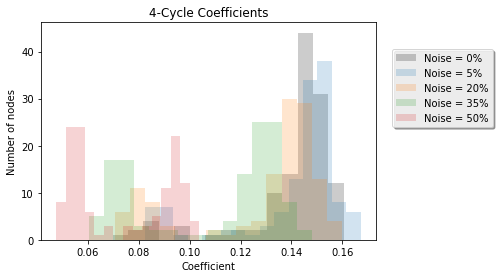

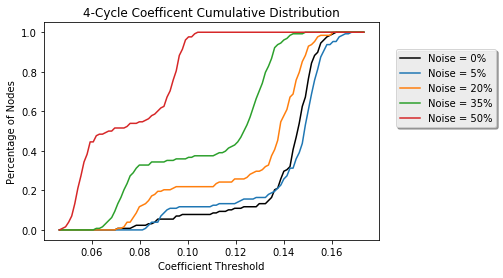

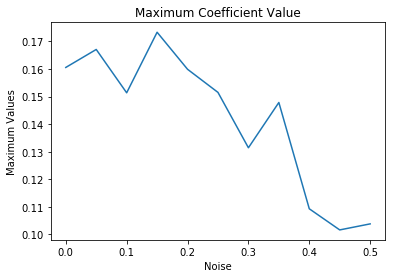

In [26]:

plt.title("4-Cycle Coefficients")
plt.hist(clean_quad, 15, alpha = 0.2, label = "Noise = 0%", color = 'k')
for i in range(0,10,3):
    plt.hist(quad_list[i], 15, alpha = 0.2, label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.xlabel("Coefficient")
plt.ylabel("Number of nodes")
plt.show()

    

thresh_list = np.linspace(np.min(quad_list), np.max(quad_list), 100)

clean_cumula_nodes = np.array([np.sum(clean_quad < thresh) for thresh in thresh_list])/128
plt.plot(thresh_list, clean_cumula_nodes, label = "Noise = 0%", c = 'k')

plt.title("4-Cycle Coefficent Cumulative Distribution")
for i in range(0,10,3):
    cumula_nodes = np.array([np.sum(quad_list[i] < thresh) for thresh in thresh_list])/128
    plt.plot(thresh_list, cumula_nodes, label = "Noise = " + str(int(200*noise_list[i])) + "%")
plt.xlabel("Coefficient Threshold")
plt.ylabel("Percentage of Nodes")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()
    


plt.title("Maximum Coefficient Value")
plt.plot(2*np.append([0], np.copy(noise_list)), np.max(np.append([clean_quad], quad_list, axis = 0), axis = 1))
plt.xlabel("Noise")
plt.ylabel("Maximum Values")
plt.show()

# <span style="color:red"> Discussion: </span>

You'll notice that noise has a couple of affects here:

    1. More noise $\implies$ lower coefficents
    2. More noise $\implies$ a greater bi-modal distribution. 
        * 50% noise gives this roughly equal weight between the two modes. 

## IDEA: 
Low clustering coefficients implies low connectivity. Can we prune the model by cutting out the nodes with lower coefficients? 

In [28]:
import pickle

pruned_data = pickle.load(open("Data_from_colab/pruning_scores_dict.h5",'rb') )


# <span style="color:red"> Pruning: </span>


Code can be found here: 

https://colab.research.google.com/drive/18POiYIPggzUOXGsKefvs6oqgMeUr2D9H

I apologize for the lack of comments--it was just a workspace for me. 

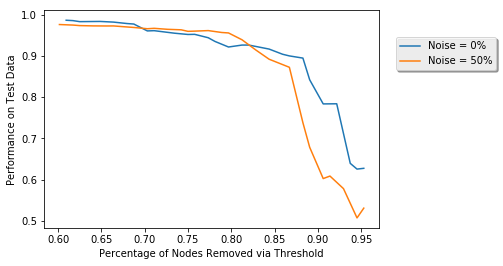

In [31]:
plt.plot(pruned_data['clean_pruning_percent_cut'], pruned_data['clean_pruning_scores'], label = "Noise = 0%")
plt.plot(pruned_data['50noisy_pruning_percent_cut'], pruned_data['50noisy_pruning_scores'], label = "Noise = 50%")


plt.xlabel("Percentage of Nodes Removed via Threshold")
plt.ylabel("Performance on Test Data")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)
plt.show()

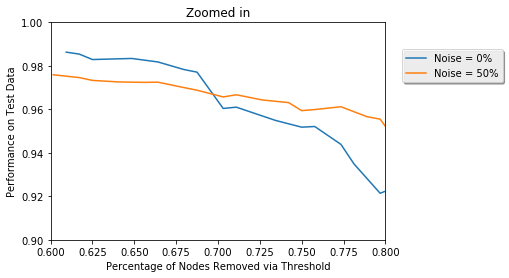

In [33]:
plt.plot(pruned_data['clean_pruning_percent_cut'], pruned_data['clean_pruning_scores'], label = "Noise = 0%")
plt.plot(pruned_data['50noisy_pruning_percent_cut'], pruned_data['50noisy_pruning_scores'], label = "Noise = 50%")


plt.xlabel("Percentage of Nodes Removed via Threshold")
plt.ylabel("Performance on Test Data")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
      ncol=1, fancybox=True, shadow=True)

plt.title("Zoomed in")
plt.xlim(0.6, 0.8)
plt.ylim(0.9,1)
plt.show()

# <span style="color:red"> Discussion: </span>

Again, a couple of things to note here:

    1. We can cut a TON of nodes and still get reasonable results. Cutting 60% keeps us roughly at the 98% level.
    2. We can cut noisy nodes more easily. Removing 80% of the nodes results in a drop in about 2% performance for the noisily trained network, whereas it drops roughly 6% for the clean trained network.
    3. The behavior qualitatively changes somewhat as we cut the more important nodes -- the noisy network starts to fail more quickly. (However, the smaller regime matters more here than later because in practice we would never want that level of performance)
    4. Sometimes even after we cut off new nodes, the performance doesn't change much. We should look into this more. It might imply redundancy. At the very least, it implies redundancy after we've pruned a ton of the network 
        ;P 
    

## Going Forward

1. How does this compare to if we pruned based off of the $l_1$ norm of the weights? They're highly correlated (see below). Other metrics? 

2. How important are individual nodes? Should try cutting some high-clustered ones to see their importance to how robust the performance is. 

3. Does training a network on noise help isolate which nodes are important? Does clustering actually 

In [36]:
def L1(arr):
    return(np.sum(np.abs(arr),axis = 1)/arr.size)

L1_in = np.array([L1(arr) for arr in dense_weights_in])
L1_out = np.array([L1(arr) for arr in dense_weights_out])

clean_L1_in = L1(clean_weights_in)
clean_L1_out = L1(clean_weights_out)

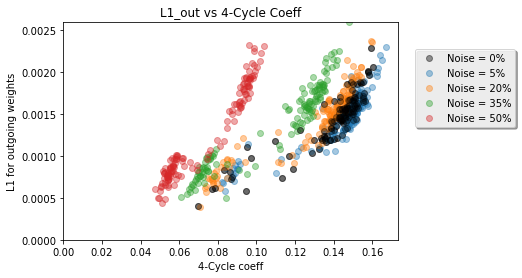

In [37]:
plt.scatter(clean_quad, clean_L1_out, alpha = 0.4, label = "Noise = 0%", c = 'k')

for i in range(0,10,3):
    plt.scatter(quad_list[i], L1_out[i], alpha = 0.4, label = "Noise = " + str(int(200*noise_list[i])) + "%")

plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9),
           ncol=1, fancybox=True, shadow=True)
plt.title("L1_out vs 4-Cycle Coeff")
plt.scatter(clean_quad, clean_L1_out, alpha = 0.3, label = "Noise = 0%", c = 'k')
plt.xlim(0, np.max(quad_list))
plt.ylim(0, np.max(L1_out))
plt.xlabel("4-Cycle coeff")
plt.ylabel("L1 for outgoing weights")
plt.show()